In [ ]:
# TA-Lib 설치 코드
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler
import collections
import pandas as pd
from sklearn import datasets
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
from tqdm import tqdm
import matplotlib.pyplot as plt
%pylab inline
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report,confusion_matrix  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3709    0  3709    0     0   7841      0 --:--:-- --:--:-- --:--:--  7841
100  503k  100  503k    0     0   437k      0  0:00:01  0:00:01 --:--:-- 2399k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3673    0  3673    0     0   8958      0 --:--:-- --:--:-- --:--:--  8958
100  406k  100  406k    0     0   392k      0  0:00:01  0:00:01 --:--:-- 1311k
Populating the interactive namespace from numpy and matplotlib


# 데이터 불러오기(original)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/original_data.csv", index_col =['Date'], parse_dates=True)

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,log_return,CCI,MA5,MA10,MA20,MA60,MA20_ratio,MA60_ratio,MA20_volume,MA60_volumne,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-19,431000.0,434000.0,424500.0,424500.0,424500.0,504352,4405.799805,3235.870117,21.670000,3097.830078,-0.010545,-94.145759,431800.0,438500.0,439525.0,413150.000000,0.965815,1.027472,665965.15,779609.133333,5051.843593,5044.528400,1884.242572,12140.316581,456049.148995,439525.0,423000.851005,-4500.0,-12000.0,16.942149,-86.567164
2021-08-20,425000.0,432000.0,421000.0,422500.0,422500.0,587940,4441.669922,3256.500000,18.559999,3060.510010,-0.004723,-100.375738,428200.0,436500.0,438650.0,414225.000000,0.963182,1.019977,643568.05,773346.983333,5534.340346,5057.375240,727.170577,12058.865397,456758.285396,438650.0,420541.714604,-2000.0,-6000.0,18.016760,-92.537313
2021-08-23,428000.0,436000.0,423500.0,429500.0,429500.0,515679,4479.529785,3342.010010,17.150000,3090.209961,0.016432,-55.850234,426800.0,435000.0,437525.0,415416.666667,0.981658,1.033902,614650.70,774623.100000,5267.825466,4714.171343,370.750404,12161.803583,454959.090168,437525.0,420090.909832,7000.0,500.0,19.972067,-71.641791
2021-08-24,435000.0,439000.0,431500.0,437500.0,437500.0,546884,4486.229980,3345.392822,17.219999,NaN,0.018455,-4.754008,428600.0,434000.0,436800.0,416666.666667,1.001603,1.050000,599231.05,777119.200000,5007.206967,4495.087997,725.455392,11971.674755,452922.654868,436800.0,420677.345132,8000.0,13000.0,20.689655,-47.761194
2021-08-25,434000.0,439000.0,432500.0,433000.0,433000.0,170243,NaN,NaN,NaN,3143.060059,-0.010339,-19.594203,429400.0,432650.0,435850.0,417766.666667,0.993461,1.036464,569861.30,773221.416667,4817.458343,4523.945382,636.116503,11580.840844,450444.862110,435850.0,421255.137890,-4500.0,10500.0,17.983651,-61.194030


In [ ]:
df = df.drop(['MA20_volume', 'MA60_volumne'], axis = 1)
#df.columns
#df = df.drop(['log_return', 'MTM1', 'MTM3'], axis = 1)
#diff = df['MA20_ratio']-df['MA60_ratio']
#df['golden'] = np.where(diff>0,1,-1)

In [ ]:
df.isnull().any()

Open          False
High          False
Low           False
Close         False
Adj Close     False
Volume        False
S&P500         True
SOX            True
VIX            True
KOSPI          True
log_return     True
CCI            True
MA5            True
MA10           True
MA20           True
MA60           True
MA20_ratio     True
MA60_ratio     True
RASD5          True
RASD10         True
MACD           True
ATR            True
ub             True
middle         True
lb             True
MTM1           True
MTM3           True
ROC            True
WPR            True
dtype: bool

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,log_return,CCI,MA5,MA10,MA20,MA60,MA20_ratio,MA60_ratio,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-31,7395.186035,7436.043457,7223.585449,7239.928223,7101.616211,1958030,1180.589966,416.989990,14.02,965.679993,-0.002255,77.408536,7277.516895,7039.726953,7114.904565,7271.660718,1.017572,0.995636,213.150136,158.625026,-12.354711,227.920020,7561.611597,7114.904565,6668.197534,-16.342773,-114.400391,3.023257,-28.155320
2005-04-01,7166.384766,7313.471680,7166.384766,7272.614258,7133.678711,1740199,1172.920044,411.220001,14.09,981.900024,0.004505,63.909019,7288.957031,7082.218652,7119.398877,7277.108374,1.021521,0.999382,181.928256,147.849453,-0.317474,222.146227,7570.531720,7119.398877,6668.266034,32.686035,-49.028809,4.705887,-22.772258
2005-04-04,7346.157227,7346.157227,7166.384766,7190.899414,7053.524414,1038979,1176.119995,409.420013,14.11,982.500000,-0.011300,56.086788,7256.271191,7110.001660,7120.624609,7280.513159,1.009869,0.987691,134.852992,141.939089,2.598465,219.119529,7572.394200,7120.624609,6668.855019,-81.714844,-65.371582,2.923979,-32.673255
2005-04-06,7174.556152,7517.758301,7174.556152,7444.214844,7302.000000,3884242,1184.069946,410.869995,13.15,988.000000,0.034621,88.750882,7267.711230,7221.133740,7126.753198,7280.785539,1.044545,1.022447,52.904059,138.366320,26.772312,213.449135,7591.889648,7126.753198,6661.616748,253.315430,171.600586,0.662983,-8.333352
2005-04-07,7517.758301,7648.501953,7493.244141,7566.787109,7422.230957,2261525,1191.140015,418.970001,12.33,988.900024,0.016331,136.064574,7333.083008,7305.299951,7140.236133,7282.283643,1.059739,1.039068,72.292447,142.721292,53.417980,212.794705,7638.779194,7140.236133,6641.693071,122.572266,375.887695,1.202186,-8.064523


In [ ]:
df.shape

(3908, 29)

# encoder로 특징 추출

In [ ]:
MA5 = df['MA5']
MA5.head()

Date
2005-03-31    7277.516895
2005-04-01    7288.957031
2005-04-04    7256.271191
2005-04-06    7267.711230
2005-04-07    7333.083008
Name: MA5, dtype: float64

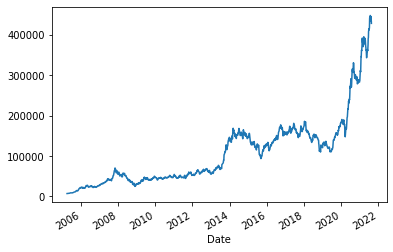

In [ ]:
MA5.plot()

In [ ]:
MA5.isnull()

Date
2005-03-31    False
2005-04-01    False
2005-04-04    False
2005-04-06    False
2005-04-07    False
              ...  
2021-08-13    False
2021-08-17    False
2021-08-18    False
2021-08-19    False
2021-08-20    False
Name: MA5, Length: 3907, dtype: bool

In [ ]:
window_length = 10
encoding_dim = 3
scaler = MinMaxScaler()
x_train = np.array([scaler.fit_transform(MA5.values[i-window_length:i].reshape(-1,1)) for i in range(window_length+1, len(MA5))])

In [ ]:
# 훈련 데이터 형태
x_train.shape

(3896, 10, 1)

In [ ]:
# 훈련 데이터셋과 테스트 데이터셋 분할
test_samples = 200 # 아직도 이거 왜 나누는지 모르겠음
x_train = x_train[:-test_samples]
x_test = x_train[-test_samples:]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 전체 데이터 중 테스트 데이터가 사용된 비중 계산
print("테스트 데이터 비중: {}%".format((test_samples/len(x_train))*100))

테스트 데이터 비중: 5.411255411255411%


In [ ]:
x_train.shape

(3696, 10, 1)

In [ ]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 20))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization_13 (Batc (None, 6)                 24        
_________________________________________________________________
dense_27 (Dense)             (None, 10)                70        
Total params: 160
Trainable params: 148
Non-trainable params: 12
_________________________________________________________________
Epoch 1/500
4/4 [==============================] - 1s 53ms/step - loss: 0.6956 - acc: 0.0909 - val_loss: 0.6825 - val_acc: 0.0350
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.6870 - acc: 0.1031 - val_loss: 0.6806 - val_acc: 0.040

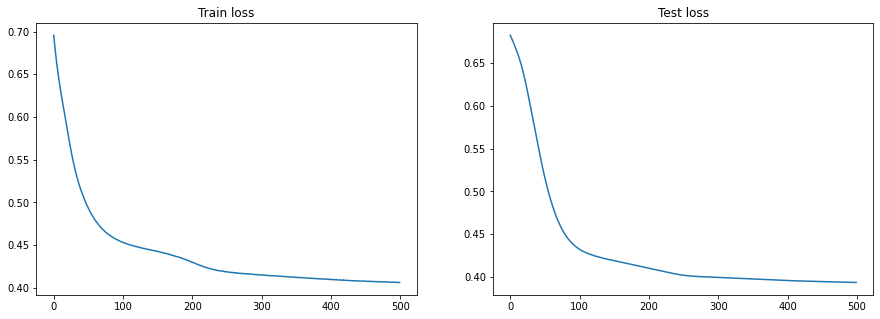

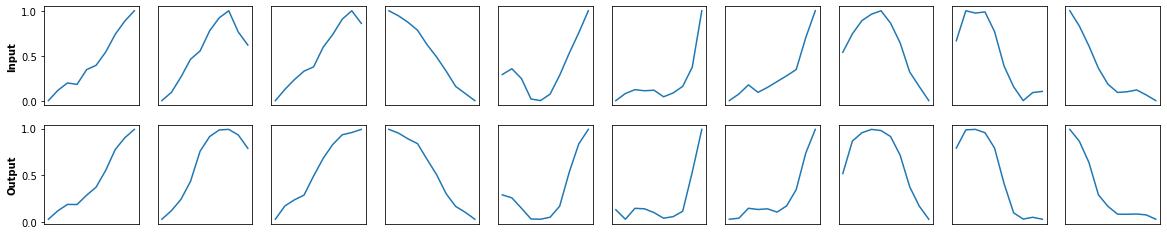

In [ ]:
from keras.callbacks import EarlyStopping
import tensorflow as tf
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

# early stopping 정의
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=500,
                batch_size=1024,
                shuffle=True,
                callbacks = [es],
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

In [ ]:
decoded_stocks

array([[0.02762344, 0.11844161, 0.18637726, ..., 0.7748903 , 0.9006505 ,
        0.99069834],
       [0.04214135, 0.08062035, 0.12573528, ..., 0.71817756, 0.87465006,
        0.9923061 ],
       [0.03083602, 0.06451842, 0.13227609, ..., 0.72922754, 0.8644161 ,
        0.990608  ],
       ...,
       [0.36419272, 0.79940003, 0.91477853, ..., 0.33158714, 0.16006306,
        0.02396265],
       [0.82880265, 0.9405859 , 0.9394896 , ..., 0.23496565, 0.1294688 ,
        0.01389146],
       [0.9731481 , 0.95245767, 0.9126656 , ..., 0.12233514, 0.08410484,
        0.01706862]], dtype=float32)

In [ ]:
compress_x_train = encoder.predict(x_train_sample)
compress_x_test = encoder.predict(x_test_sample)

In [ ]:
new_feature = np.concatenate([compress_x_train, compress_x_test])
tmp_df = pd.DataFrame(new_feature, columns = ['comp_fe1', 'comp_fe2', 'comp_fe3'])

In [ ]:
tmp_df.shape

(3896, 3)

In [ ]:
n_df = df.iloc[11:]
tmp_df.index = n_df.index

In [ ]:
tmp_df

,comp_fe1,comp_fe2,comp_fe3
Date,,,
2005-04-18,0.000000,0.000000,0.0
2005-04-19,0.178179,0.000000,0.0
2005-04-20,0.330656,0.099895,0.0
2005-04-21,0.291000,0.089868,0.0
2005-04-22,0.000000,0.000000,0.0
...,...,...,...
2021-08-13,0.290627,0.046508,0.0
2021-08-17,0.221219,0.006705,0.0
2021-08-18,0.117215,0.000000,0.0


In [ ]:
df = pd.merge(df, tmp_df,left_index=True, right_index=True,how='inner')

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'S&P500', 'SOX',
       'VIX', 'KOSPI', 'CCI', 'MA5', 'MA10', 'RASD5', 'RASD10', 'MACD', 'ATR',
       'ub', 'middle', 'lb', 'ROC', 'WPR', 'MA20', 'MA60', 'MA20_ratio',
       'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'comp_fe1', 'comp_fe2',
       'comp_fe3'],
      dtype='object')

In [ ]:
df = df.drop(columns = ['MA5'], axis = 1)

# feature

In [ ]:
df['next_price'] = df['Close'].shift(-30) # 30일 후 예상

# 라벨링

In [ ]:
diffs = df['next_price']-df['Close']
df['label'] = np.where(diffs>0,1,0)

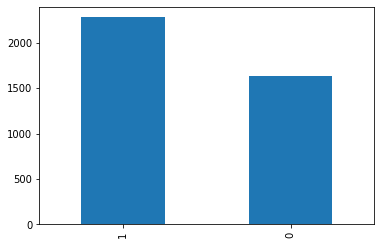

In [ ]:
df['label'].value_counts().plot.bar()

In [ ]:
# 예측기간 2011-01-03 ~ 2020-12-31
df = df.loc['2011-01-03':'2020-12-31']
df.head()


,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,log_return,CCI,MA5,MA10,MA20,MA60,MA20_ratio,MA60_ratio,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR,next_price,label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,56138.042969,56260.617188,53931.746094,54299.460938,53262.128906,620732,1271.869995,415.049988,17.610001,2070.080078,-0.024527,154.460116,53122.768750,52031.876563,49623.333984,48967.572917,1.094232,1.108886,1236.712248,1151.430055,1620.414990,1677.743121,55274.042427,49623.333984,43972.625542,-1348.292969,2451.441406,4.481133,-20.512837,47435.421875,0
2011-01-04,54789.750000,55280.039062,53196.312500,54299.460938,53262.128906,622788,1270.199951,415.579987,17.379999,2085.139893,0.000000,110.166821,53907.230469,52313.792578,50058.465039,48998.215951,1.084721,1.108193,1380.811404,1117.982020,1703.556372,1706.741938,55742.112759,50058.465039,44374.817319,0.000000,858.003906,3.504673,-20.512837,44493.691406,0
2011-01-05,53686.601562,55770.328125,53686.601562,54544.605469,53502.585938,764757,1276.560059,417.089996,17.020000,2082.550049,0.004504,104.650453,54446.547656,52742.794922,50475.210352,49034.987565,1.080622,1.112361,1397.787736,1046.805197,1768.837573,1733.669411,56191.121155,50475.210352,44759.299548,245.144531,-1103.148438,4.215453,-18.918935,46454.843750,0
2011-01-06,55034.894531,55280.039062,53809.171875,54299.460938,53262.128906,779263,1273.849976,424.769989,17.400000,2077.610107,-0.004504,80.880012,54618.148438,53049.225391,50861.312500,49088.102148,1.067599,1.106163,1270.956296,989.796333,1780.270430,1714.897824,56514.785614,50861.312500,45207.839386,-245.144531,0.000000,6.235010,-25.806465,45596.839844,0
2011-01-07,54299.460938,55770.328125,54299.460938,55157.464844,54103.734375,826631,1271.500000,425.760010,17.139999,2086.199951,0.015678,89.220552,54520.090625,53416.941797,51259.671875,49165.731120,1.076040,1.121868,931.557834,956.362888,1837.384571,1697.467064,56945.011148,51259.671875,45574.332602,858.003906,858.003906,9.223294,-15.789515,45596.839844,0


In [ ]:
X = df.drop(['next_price','label'], axis=1)
y = df['label']

y.shape

(2361,)

In [ ]:
X.shape

(2361, 29)

# 전처리

In [ ]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

le = LabelEncoder()        
y = le.fit_transform(y)   


In [ ]:
sum(y)/len(df) * 100

56.3744176196527

In [ ]:
X_scaled.shape

(2361, 29)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234, stratify=y)

# 함수 정의

In [ ]:
def report(clf):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Random Forest Accuracy:', np.mean(y_pred == y_test))
    ax = plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=0.5, fmt='.1f', annot=True)

In [ ]:
def feature_importance(clf):
    feature_importance = clf.feature_importances_
    # plot
    df_fi = pd.DataFrame({'columns':X.columns, 'importances':feature_importance})
    df_fi = df_fi[df_fi['importances'] > 0] # importance가 0이상인 것만 
    df_fi = df_fi.sort_values(by=['importances'], ascending=False)

    fig = plt.figure(figsize=(15,7))
    ax = sns.barplot(df_fi['columns'], df_fi['importances'])
    ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
    plt.tight_layout()
    plt.show()

# 모델

In [ ]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C= 0.1,random_state=1)
tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=41,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)

lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(tree_method='hist',random_state=41)

adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=100,
                                learning_rate = 0.01, 
                                random_state=42)

clf_labels = ['Random forest','Ada boost','XGB','LIGHTGBM']

all_clf = [ forest,adaboost,xgb,lgb]

In [ ]:
'''
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[700],
    'max_depth' : [4, 6, 8, 10,50,200], 
    'min_samples_leaf' : [0,1,2,8, 12, 18],
    'min_samples_split' : [0,1,2,8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
grid_cv = GridSearchCV(forest, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
'''

"\nfrom sklearn.model_selection import GridSearchCV\n\nparams = {\n    'n_estimators':[700],\n    'max_depth' : [4, 6, 8, 10,50,200], \n    'min_samples_leaf' : [0,1,2,8, 12, 18],\n    'min_samples_split' : [0,1,2,8, 16, 20]\n}\n# RandomForestClassifier 객체 생성 후 GridSearchCV 수행\ngrid_cv = GridSearchCV(forest, param_grid=params, cv=2, n_jobs=-1)\ngrid_cv.fit(X_train, y_train)\n\nprint('최적 하이퍼 파라미터:\n', grid_cv.best_params_)\nprint('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))\n"

# AUC 검정

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.979 (+/- 0.008) [Random forest]
ROC AUC: 0.932 (+/- 0.020) [Ada boost]
ROC AUC: 0.933 (+/- 0.016) [XGB]
ROC AUC: 0.975 (+/- 0.010) [LIGHTGBM]


# ROC 커브

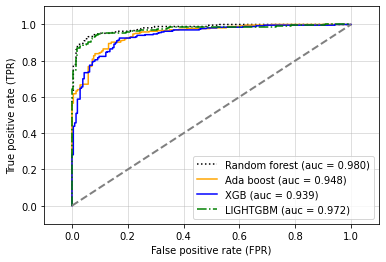

In [ ]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '-','solid','dashdot']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

# RF

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       206
           1       0.93      0.94      0.94       267

    accuracy                           0.93       473
   macro avg       0.93      0.93      0.93       473
weighted avg       0.93      0.93      0.93       473

Random Forest Accuracy: 0.9302325581395349


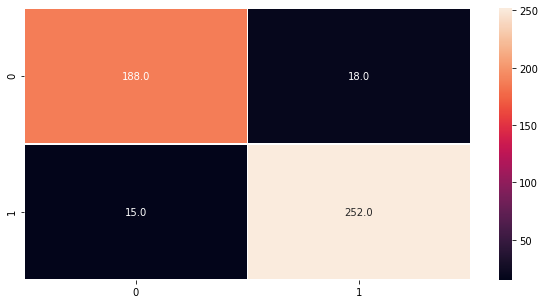

In [ ]:
report(forest)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


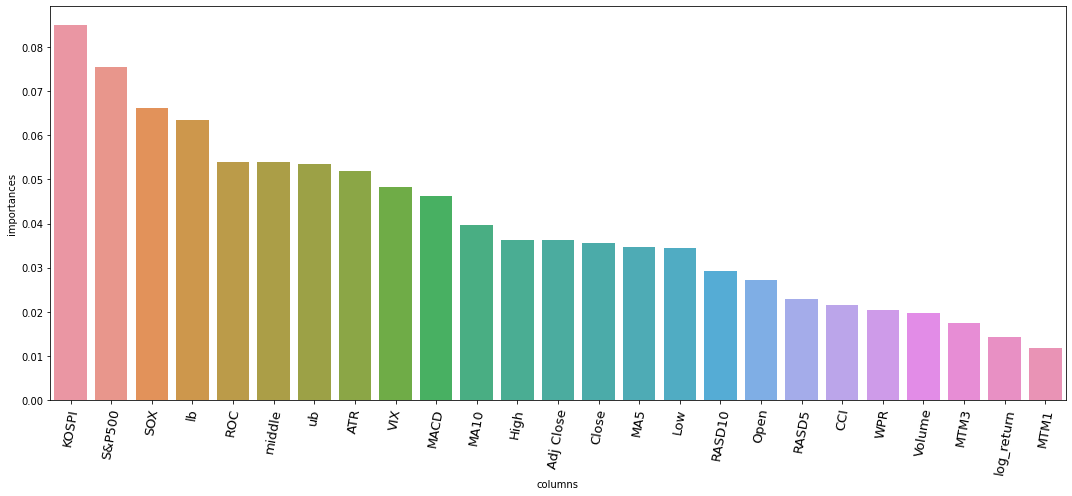

In [ ]:
feature_importance(forest)

# voting

In [ ]:
report(voting)

NotFittedError: ignored

# DT

In [ ]:
report(tree)

In [ ]:
feature_importance(forest)

# LGBM

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       215
           1       0.70      0.68      0.69       273

    accuracy                           0.66       488
   macro avg       0.66      0.66      0.66       488
weighted avg       0.66      0.66      0.66       488

Random Forest Accuracy: 0.6598360655737705


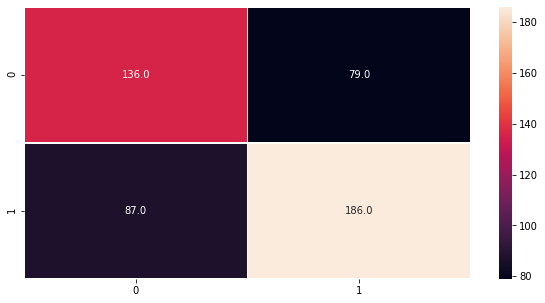

In [ ]:
report(lgb)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


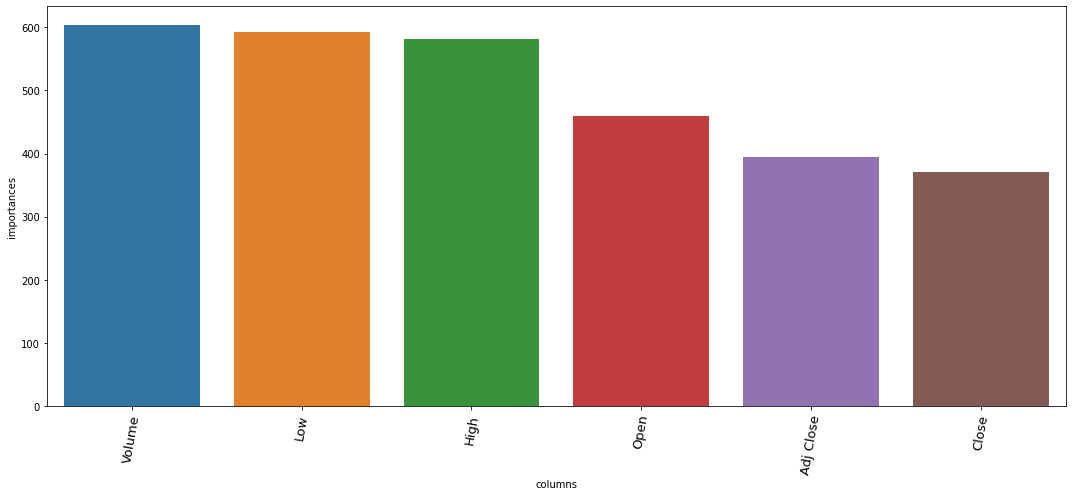

In [ ]:
feature_importance(lgb)

#XGB

In [ ]:
report(xgb)

In [ ]:
feature_importance(xgb)

# ADA

              precision    recall  f1-score   support

           0       0.63      0.46      0.53       215
           1       0.65      0.79      0.71       273

    accuracy                           0.65       488
   macro avg       0.64      0.63      0.62       488
weighted avg       0.64      0.65      0.63       488

Random Forest Accuracy: 0.6454918032786885


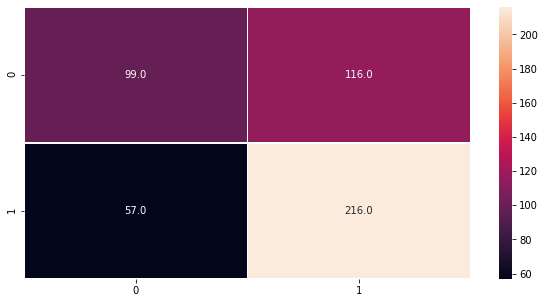

In [ ]:
report(adaboost)

              precision    recall  f1-score   support

           0       0.63      0.46      0.53       215
           1       0.65      0.79      0.71       273

    accuracy                           0.65       488
   macro avg       0.64      0.63      0.62       488
weighted avg       0.64      0.65      0.63       488

Random Forest Accuracy: 0.6454918032786885


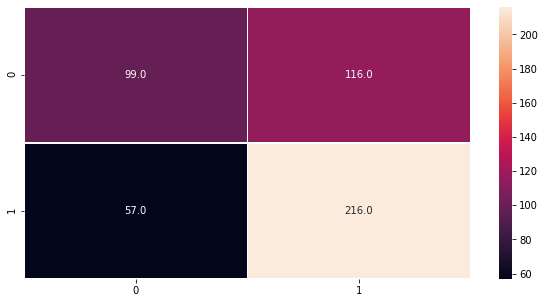

In [ ]:
report(adaboost)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


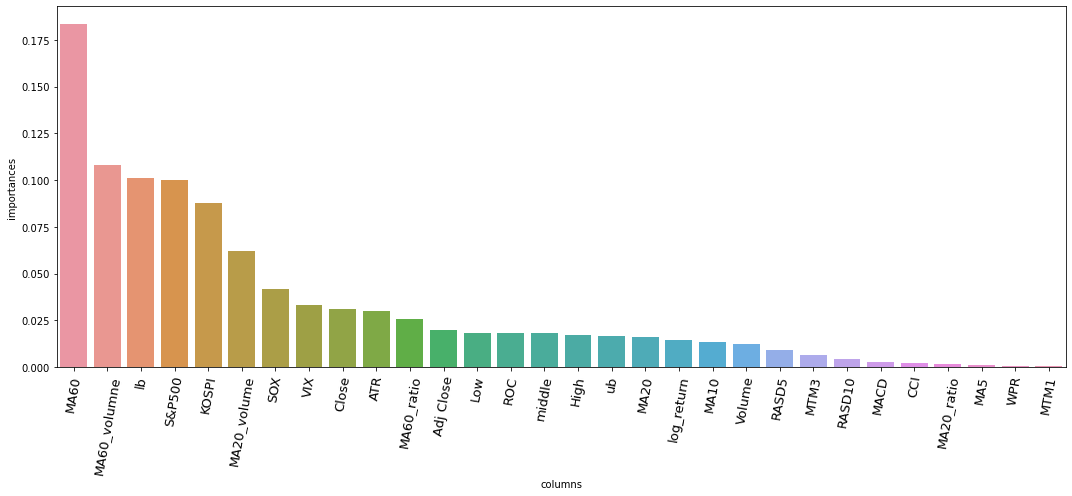

In [ ]:
feature_importance(adaboost)